In [1]:
from pathlib import Path
import boule as bl
import ensaio
import pygmt
import verde as vd
import xarray as xr

import harmonica as hm

In [2]:
dark_mode = True

if dark_mode:
    color = "white"
else:
    color = "black"

pygmt.config(
    FONT_ANNOT=f"11p,Helvetica,{color}",
    FONT_TITLE=f"12p,Helvetica,{color}",
    FONT_LABEL=f"10p,Helvetica,{color}",
    MAP_TITLE_OFFSET="0p",
    MAP_FRAME_WIDTH="2p",
)


In [3]:
figs_dir = Path("..") / "figs"

In [4]:
# Load the global gravity, topography, and geoid grids
fname_gravity = ensaio.fetch_earth_gravity(version=1)
fname_geoid = ensaio.fetch_earth_geoid(version=1)
fname_topo = ensaio.fetch_earth_topography(version=1)
data = xr.merge(
    [
        xr.load_dataarray(fname_gravity),
        xr.load_dataarray(fname_geoid),
        xr.load_dataarray(fname_topo),
    ]
)
print(data)

<xarray.Dataset>
Dimensions:     (longitude: 2161, latitude: 1081)
Coordinates:
  * longitude   (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude    (latitude) float64 -90.0 -89.83 -89.67 ... 89.67 89.83 90.0
    height      (latitude, longitude) float32 1e+04 1e+04 1e+04 ... 1e+04 1e+04
Data variables:
    gravity     (latitude, longitude) float32 9.801e+05 9.801e+05 ... 9.802e+05
    geoid       (latitude, longitude) float32 -29.5 -29.5 -29.5 ... 15.4 15.4
    topography  (latitude, longitude) float32 2.742e+03 2.742e+03 ... -4.237e+03
Attributes:
    Conventions:     CF-1.8
    title:           Gravity acceleration (EIGEN-6C4) at a constant geometric...
    crs:             WGS84
    source:          Generated from the EIGEN-6C4 model by the ICGEM Calculat...
    license:         Creative Commons Attribution 4.0 International Licence
    references:      https://doi.org/10.5880/icgem.2015.1
    long_name:       gravity acceleration
    description:     magn

In [5]:
# Calculate normal gravity and the disturbance
ellipsoid = bl.WGS84
gamma = ellipsoid.normal_gravity(data.latitude, data.height)
disturbance = data.gravity - gamma

In [6]:
# Reference the topography to the ellipsoid
topography_ell = data.topography + data.geoid

In [7]:
# Calculate the Bouguer planar correction and the topography-free disturbance.
# Use the default densities for the crust and ocean water.
bouguer = hm.bouguer_correction(topography_ell)
disturbance_topofree = disturbance - bouguer

grdgradient [WARNING]: Longitude range too small; geographic boundary condition changed to natural.
grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.


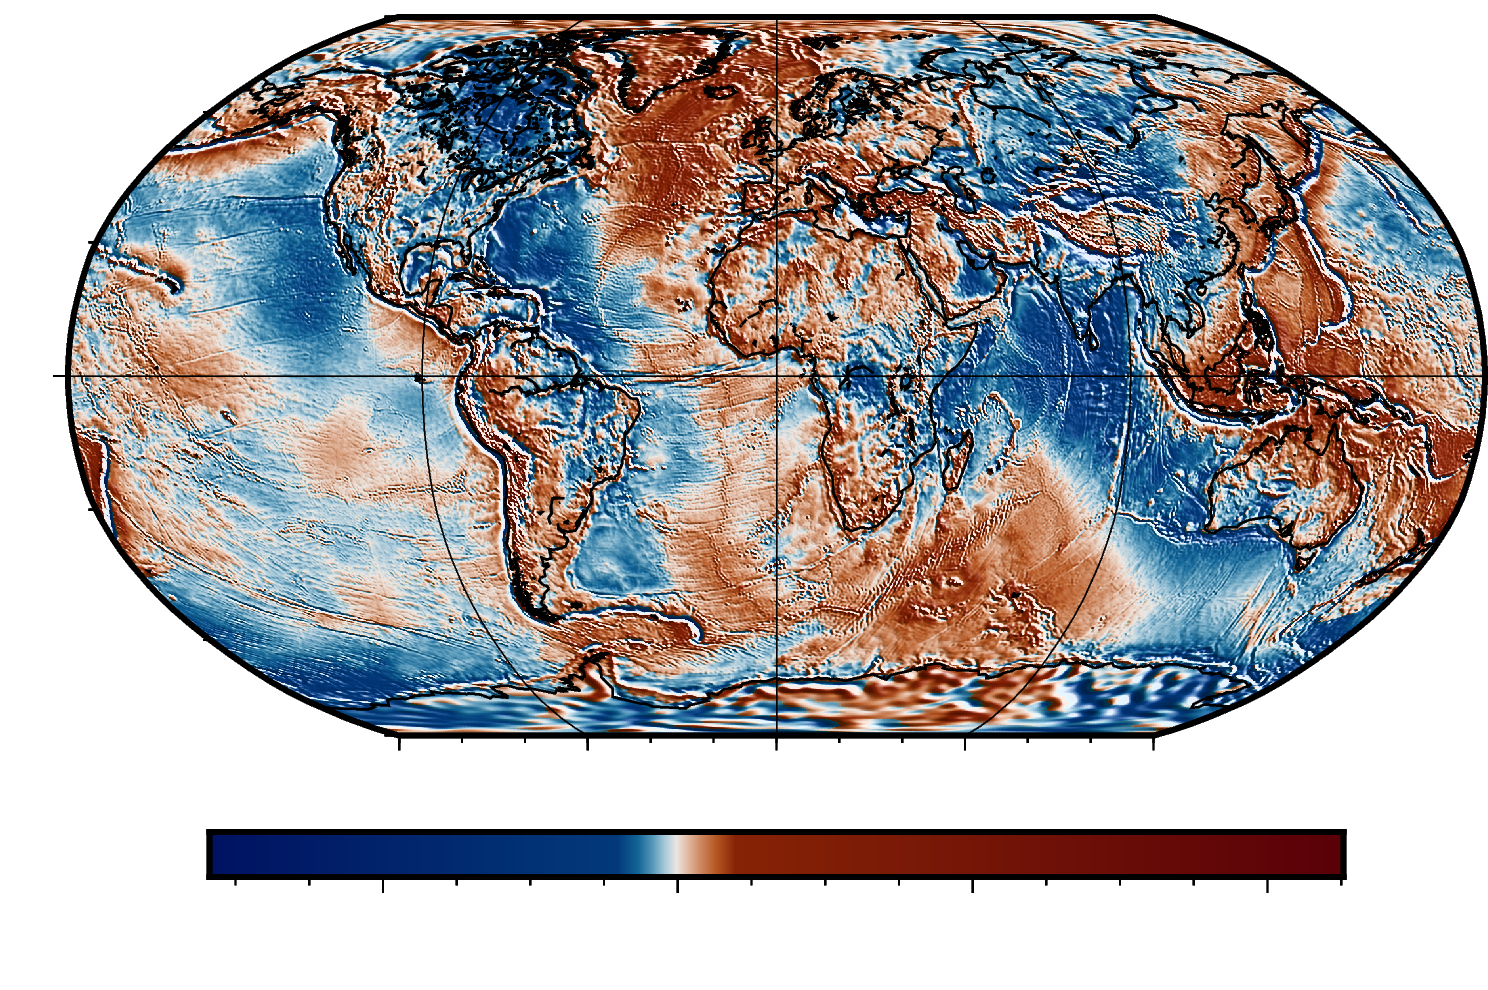

In [8]:
# Make a plot of data using PyGMT
gmt_projection = "N12c"

fig = pygmt.Figure()

# vmin, vmax = disturbance.values.min(), disturbance.values.max()
# maxabs = 0.2 * max(abs(vmin), abs(vmax))
pygmt.grd2cpt(grid=disturbance, cmap="vik", continuous=True)

fig.grdimage(
    disturbance,
    projection=gmt_projection,
    frame="afg",
    shading="+a45+n150",
    cmap=True,
)
fig.coast(shorelines="0.5p,black", resolution="crude")
fig.colorbar(cmap=True, frame=["a200f50", "x+lmGal"])
fig.show()

grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.


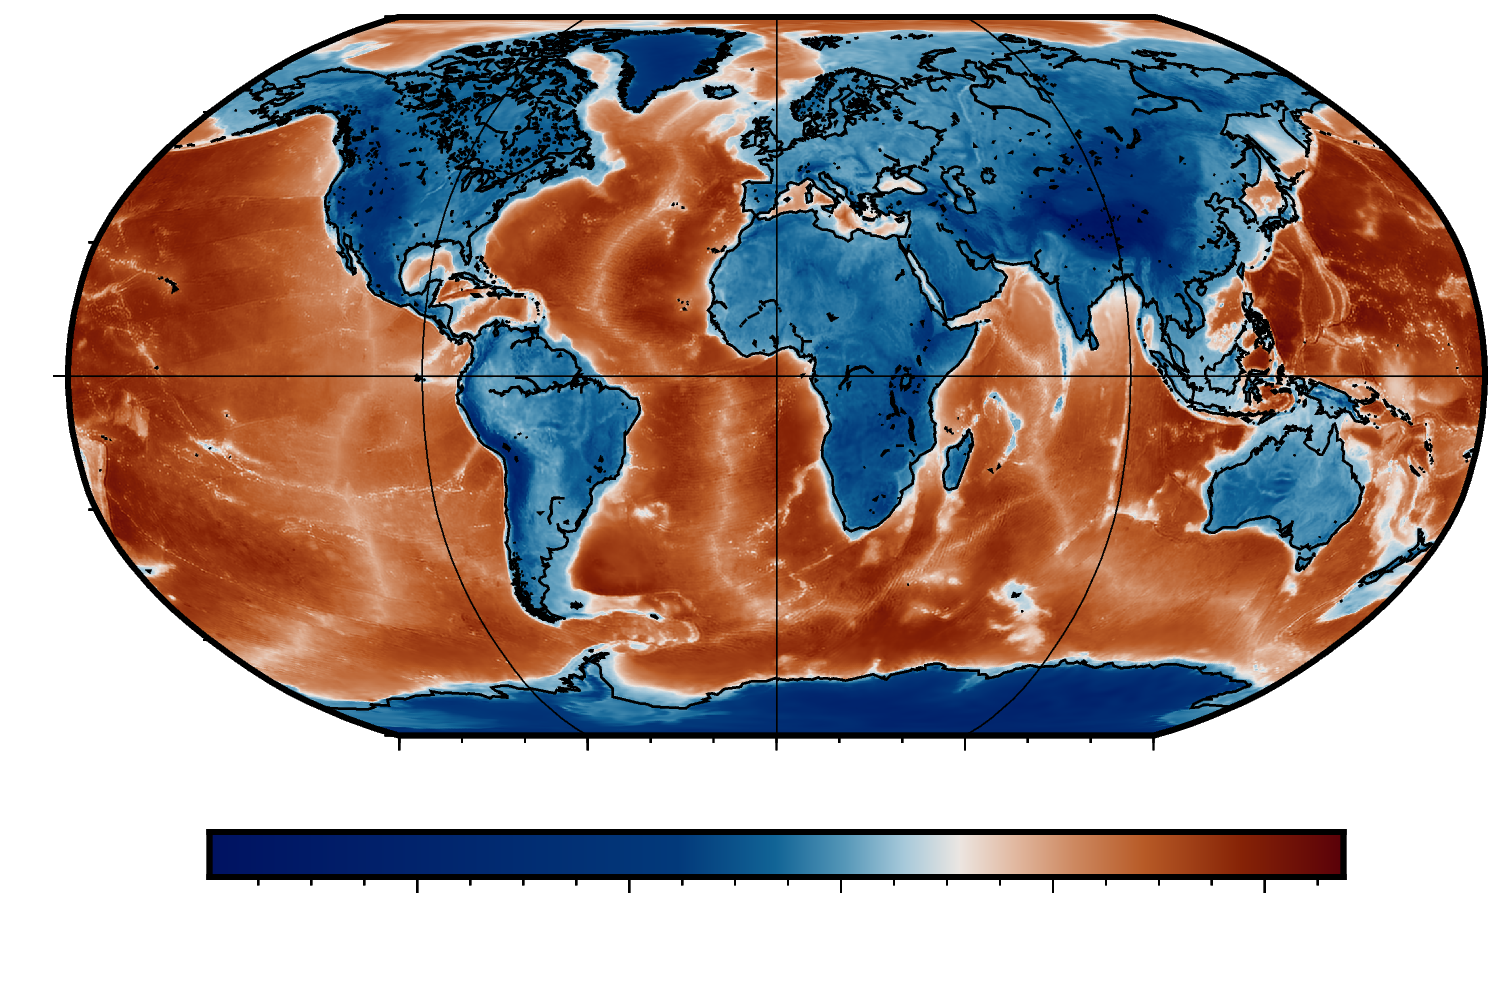

In [9]:
# Make a plot of data using PyGMT
gmt_projection = "N12c"

fig = pygmt.Figure()

pygmt.grd2cpt(grid=disturbance_topofree, cmap="vik+h0", continuous=True)

fig.grdimage(
    disturbance_topofree,
    projection=gmt_projection,
    frame="afg",
    cmap=True,
)
fig.coast(shorelines="0.5p,black", resolution="crude")
fig.colorbar(cmap=True, frame=["a200f50", "x+lmGal"])
fig.show()

grdgradient [WARNING]: Longitude range too small; geographic boundary condition changed to natural.
grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.


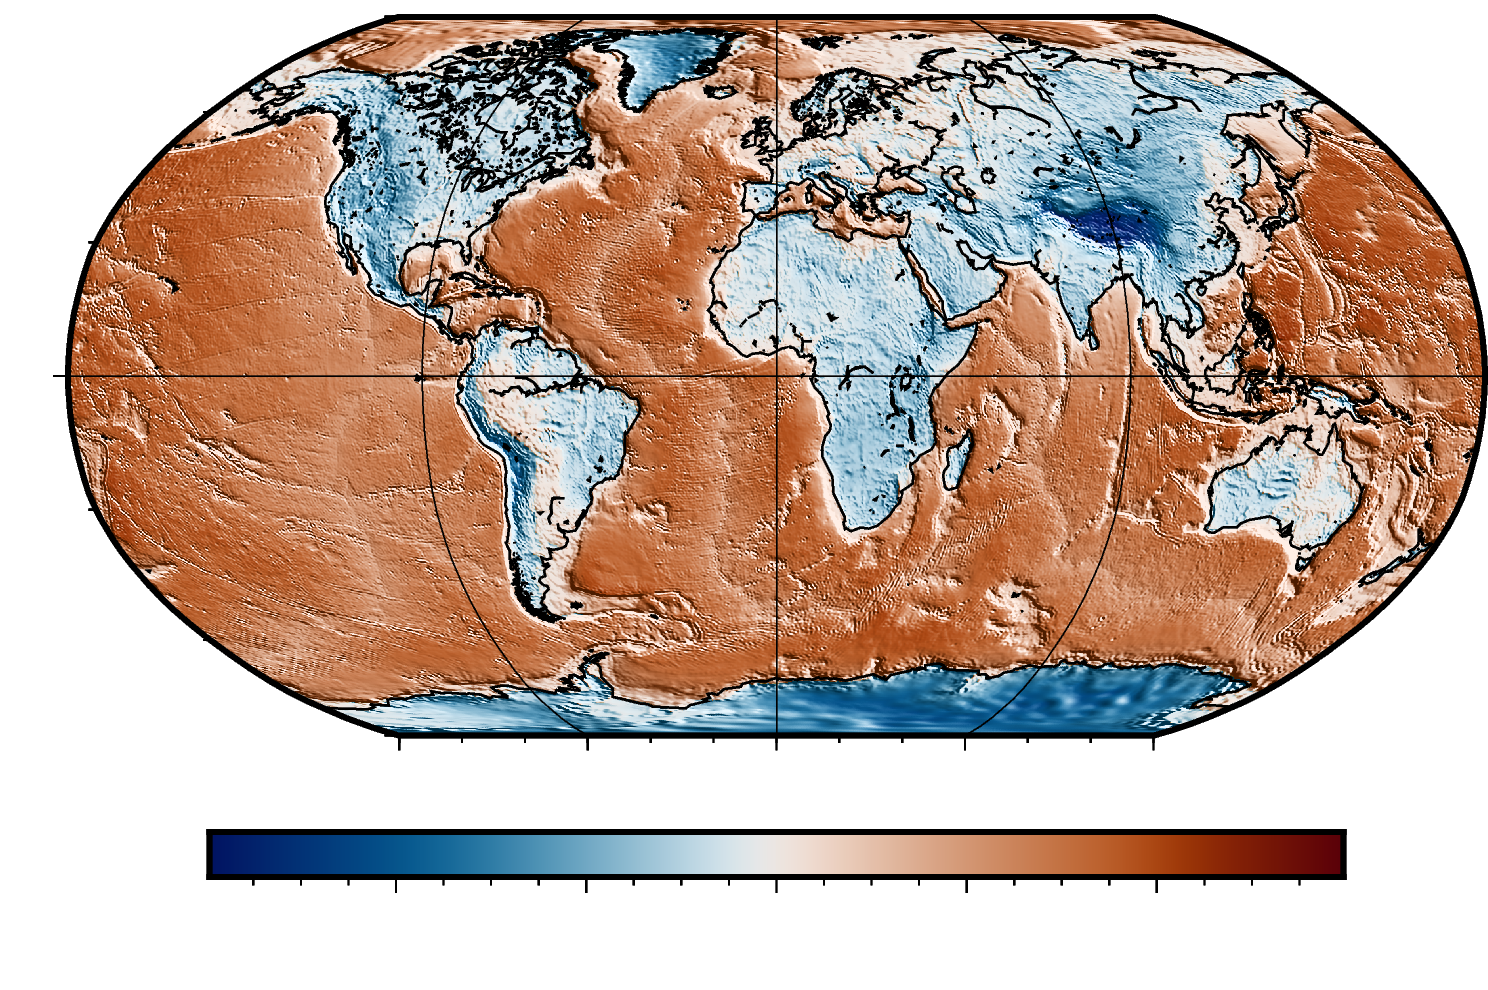

In [10]:
# Make a plot of data using PyGMT
gmt_projection = "N12c"

fig = pygmt.Figure()

maxabs = vd.maxabs(disturbance_topofree)
pygmt.makecpt(series=[-maxabs, maxabs], cmap="vik")

fig.grdimage(
    disturbance_topofree,
    projection=gmt_projection,
    frame="afg",
    shading="+a45+n70",
    cmap=True,
)
fig.coast(shorelines="0.5p,black", resolution="crude")
fig.colorbar(cmap=True, frame=["a200f50", "x+lmGal"])
fig.savefig(figs_dir / "earth-bouguer.png", dpi=300, transparent=True)
fig.show()

## Plot mid ocean ridges

In [11]:
region = (-65, 0, 40, 60)  # W, E, S, N

In [12]:
dist_topofree_ridge = disturbance_topofree.sel(
    longitude=slice(*region[:2]),
    latitude=slice(*region[2:]),
) 
dist_topofree_ridge

<xarray.DataArray (latitude: 121, longitude: 391)>
array([[267.22863104, 271.07408236, 276.53461297, ..., -13.80971727,
          5.0613113 ,  18.32747171],
       [263.9223148 , 270.41834562, 275.13195605, ..., -41.89626261,
        -20.28706836,  -0.38227683],
       [259.29654032, 267.06186115, 272.39739176, ..., -70.36924705,
        -48.79644669, -26.85603796],
       ...,
       [-32.18276687, -40.9902243 , -46.42794702, ...,  18.25580283,
         18.32028676,  18.8271214 ],
       [-17.33887228, -25.10150911, -29.87598027, ...,  16.49554171,
         16.85499973,  18.2076226 ],
       [ -4.03309917, -10.37971832, -14.15985262, ...,  15.53263494,
         15.5112503 ,  17.02800564]])
Coordinates:
  * longitude  (longitude) float64 -65.0 -64.83 -64.67 ... -0.3333 -0.1667 0.0
  * latitude   (latitude) float64 40.0 40.17 40.33 40.5 ... 59.67 59.83 60.0
    height     (latitude, longitude) float32 1e+04 1e+04 1e+04 ... 1e+04 1e+04

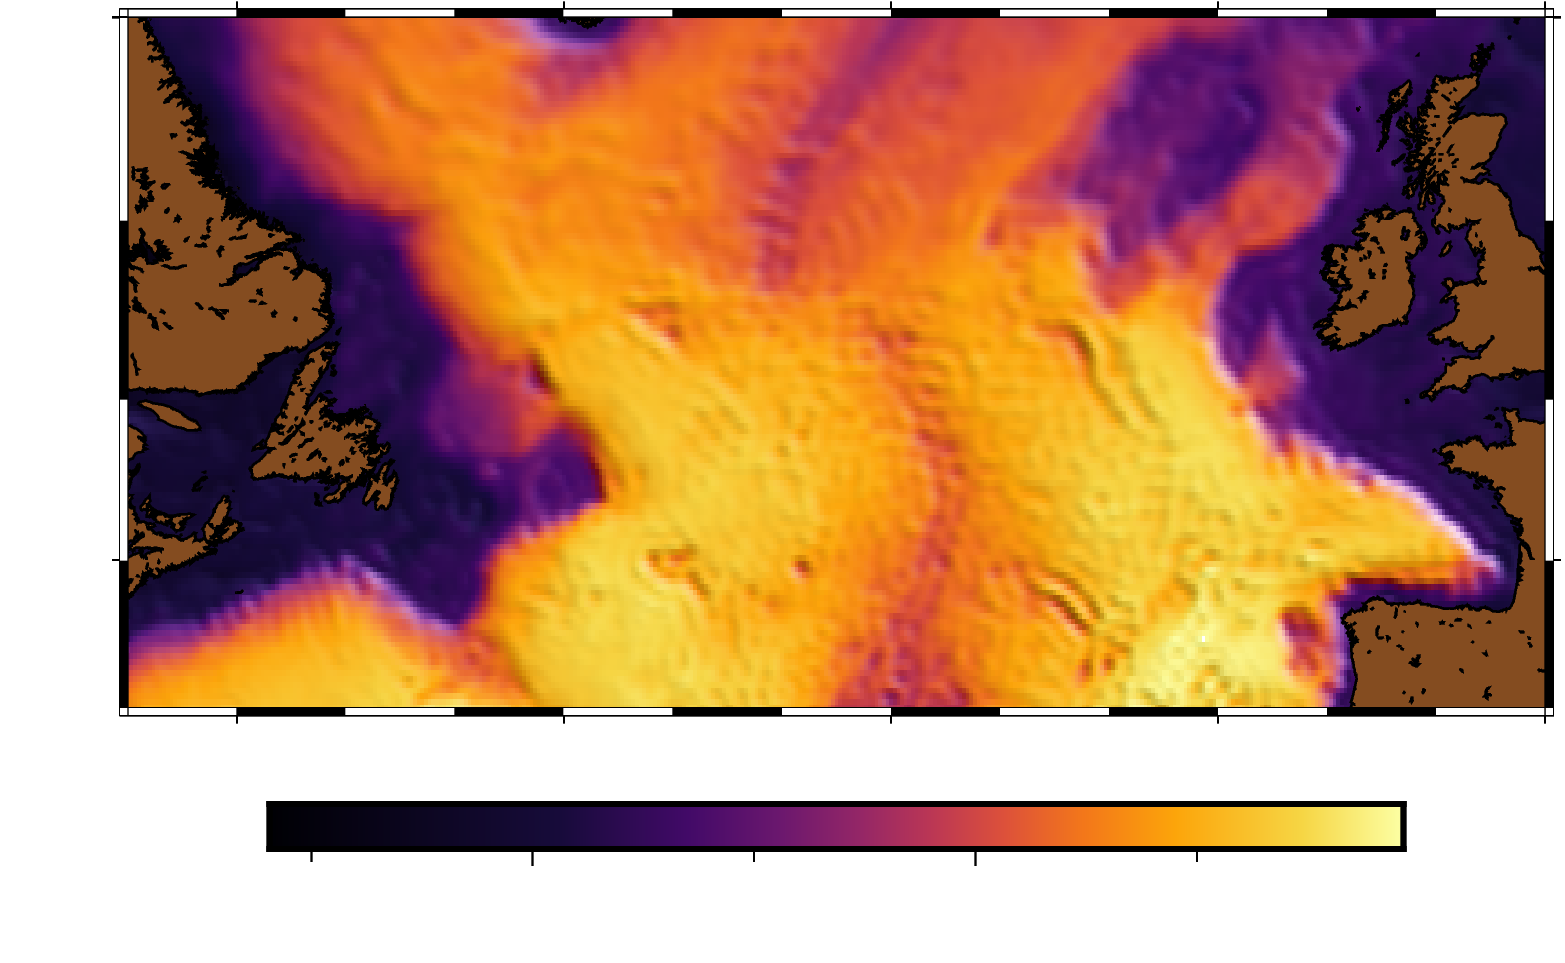

In [13]:
gmt_projection = "M12c"

fig = pygmt.Figure()
pygmt.grd2cpt(dist_topofree_ridge, cmap="inferno", continuous=True)
fig.grdimage(
    dist_topofree_ridge,
    projection=gmt_projection,
    shading="+a45+n1",
    cmap=True,
)
fig.coast(shorelines="0.5p,black", land="#844c20", resolution="intermediate")
fig.basemap(frame=True)
fig.colorbar(frame='af+l"mGal"')
fig.savefig(figs_dir / "ridge-gravity.png", dpi=300, transparent=True)
fig.show()